In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load JSON
with open("2layers_reflectivity_model_config.json") as f:
    data = json.load(f)

energies = [float(e.split("_")[0]) for e in data["energy_pol_uni"]]
layers = data["layers"]


In [2]:
data["layers"]

[{'name': 'UL',
  'is_substrate': False,
  'fit_thickness': {'x0': 101.98979874236144,
   'delta': None,
   'bounds': [88, 102]},
  'fit_roughness': {'x0': 1.8768793042720338, 'delta': None, 'bounds': [0, 2]},
  'fit_nk_array': {'n_array': [0.002061536581221818,
    0.00045191935782081297,
    0.0003652498536507882,
    0.0009144723040193985,
    -0.005773320624726166,
    0.002146928860989051,
    0.0014881318000654587,
    0.0002625126127315659,
    0.0004749670817957606,
    0.0002624696542134395,
    0.00017677352652202633],
   'k_array': [0.0013212853920866138,
    0.0006441172921580283,
    0.0006966273667992524,
    0.0008605527833837881,
    0.0026502372915997584,
    0.0020515704915988996,
    0.00152830823999259,
    0.001345252359250254,
    0.001708665372934778,
    0.002188881633072187,
    0.00268494664061789],
   'bounds_n': [-0.01, 0.01],
   'bounds_k': [0, 0.01]}},
 {'name': 'oxide',
  'is_substrate': False,
  'fixed_thickness': 1.1,
  'fixed_roughness': 0.01,
  'fixed

In [3]:
def plot_nk(layer, energies):
    name = layer["name"]
    if "fit_nk_array" in layer:
        n = layer["fit_nk_array"]["n_array"]
        k = layer["fit_nk_array"]["k_array"]
    elif "fixed_nk" in layer:
        n = layer["fixed_nk"]["n_array"]
        k = layer["fixed_nk"]["k_array"]
    else:
        return

    plt.figure(figsize=(10, 4))
    plt.plot(energies, n, label="n", marker="o")
    plt.plot(energies, k, label="k", marker="s")
    plt.title(f"📡 Optical Constants for Layer: {name}")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_685941/3118386213.py:20: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kas/Projects/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


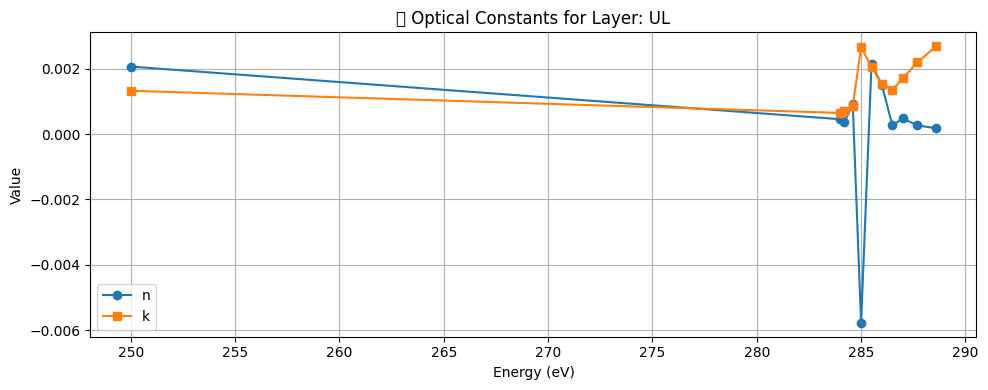

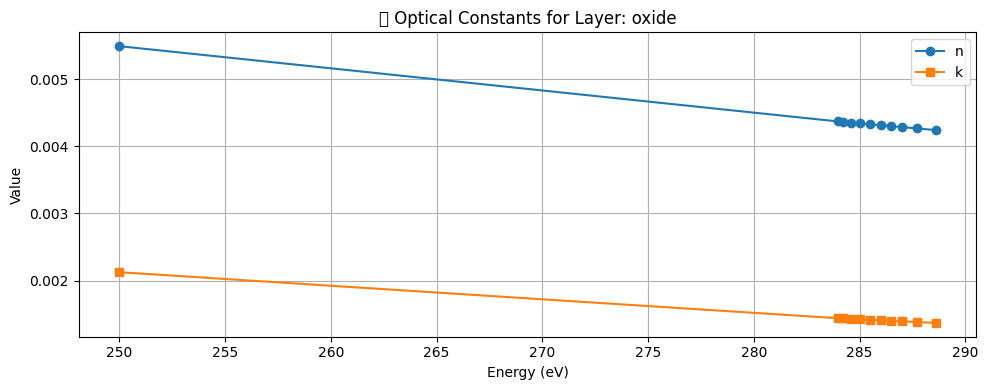

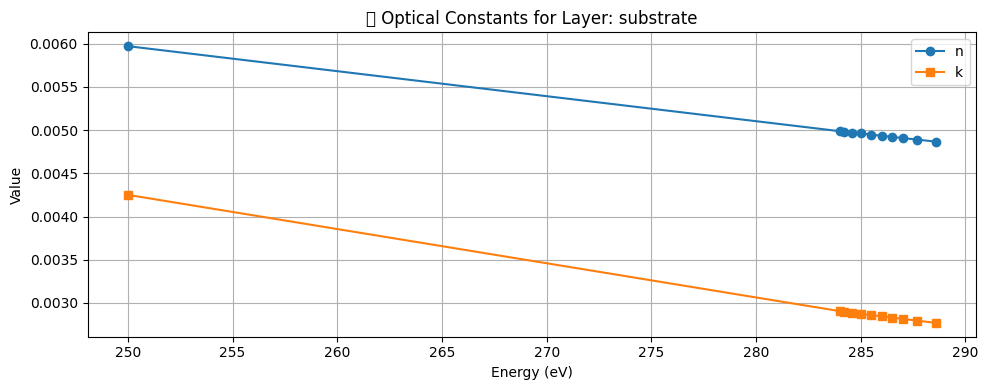

In [4]:
for layer in layers:
    plot_nk(layer, energies)

In [5]:
import numpy as np
from scipy.special import erf

def smooth_transition(z, z0, width, val1, val2):
    """Smooth transition between val1 and val2 centered at z0 with roughness width."""
    return val1 + (val2 - val1) * 0.5 * (1 + erf((z - z0) / (np.sqrt(2) * width)))

def get_thick_rough(layer):
    thickness = 0
    roughness = 0
    if "fit_thickness" in layer and "x0" in layer["fit_thickness"]:
        thickness = layer["fit_thickness"]["x0"]
    elif "fixed_thickness" in layer:
        thickness = layer["fixed_thickness"]

    if "fit_roughness" in layer and "x0" in layer["fit_roughness"]:
        roughness = layer["fit_roughness"]["x0"]
    elif "fixed_roughness" in layer:
        roughness = layer["fixed_roughness"]
    return thickness, roughness

def get_nk(layer,target_energy_index=0):
    if "fit_nk_array" in layer:
        n = layer["fit_nk_array"]["n_array"][target_energy_index]
        k = layer["fit_nk_array"]["k_array"][target_energy_index]
    else:
        n = layer["fixed_nk"]["n_array"][target_energy_index]
        k = layer["fixed_nk"]["k_array"][target_energy_index]
    return n, k
    


def build_centered_erf_profile(layers, energies, target_energy_index=0, resolution=0.1):
    # Parameters
    vacuum_thickness = 10
    substrate_extension = 10
    vacuum_n, vacuum_k = 0.0, 0.0

    # Compute total stack thickness
    stack_thickness = sum(
        layer.get("fit_thickness", {}).get("x0", layer.get("fixed_thickness", 0))
        for layer in layers
    )
    total_depth = vacuum_thickness + stack_thickness + substrate_extension
    z_grid = np.arange(-vacuum_thickness, stack_thickness + substrate_extension, resolution)

    n_profile = np.full_like(z_grid, vacuum_n, dtype=float)
    k_profile = np.full_like(z_grid, vacuum_k, dtype=float)



    z_current = 0
    prev_n, prev_k = vacuum_n, vacuum_k

    for i, layer in enumerate(layers[:-1]):
        #print(layer)
        #thickness = layer.get("fit_thickness").get("x0", layer.get("fixed_thickness"))
        #roughness = layer.get("fit_roughness").get("x0", layer.get("fixed_roughness"))
        thickness, roughness = get_thick_rough(layer)
        n_val, k_val = get_nk(layer,target_energy_index=target_energy_index)

        # Fill interior of layer
        for j, z in enumerate(z_grid):
            if z_current <= z < z_current + thickness:
                n_profile[j] = n_val
                k_profile[j] = k_val

        # Apply smooth transition centered at interface
        z_interface = z_current
        width = roughness / 2
        for j, z in enumerate(z_grid):
            if z_interface - 3 * width < z < z_interface + 3 * width:
                alpha = 0.5 * (1 + erf((z - z_interface) / (np.sqrt(2) * width)))
                n_profile[j] = (1 - alpha) * prev_n + alpha * n_val
                k_profile[j] = (1 - alpha) * prev_k + alpha * k_val

        z_current += thickness
        prev_n, prev_k = n_val, k_val

    # Final transition to substrate extension
    last_layer = layers[-1]
    rough_substrate = last_layer.get("fit_roughness", {}).get("x0", last_layer.get("fixed_roughness", 0.01))
    #print(rough_substrate)
    sub_n, sub_k = get_nk(last_layer,target_energy_index=target_energy_index)
    z_interface = z_current
    width = rough_substrate / 2

    for j, z in enumerate(z_grid):
        if z_interface - 3 * width < z < z_interface + 3 * width:
            alpha = 0.5 * (1 + erf((z - z_interface) / (np.sqrt(2) * width)))
            n_profile[j] = (1 - alpha) * prev_n + alpha * sub_n
            k_profile[j] = (1 - alpha) * prev_k + alpha * sub_k
        elif z >= z_interface + 3 * width:
            n_profile[j] = sub_n
            k_profile[j] = sub_k

    return z_grid, n_profile, k_profile

In [6]:
data["layers"][0]['fit_roughness']['x0'] = 0
data["layers"][1]['fixed_roughness'] = 0
data["layers"][1]['fixed_thickness'] = 5
data["layers"][2]['fixed_roughness'] = 1

/tmp/ipykernel_685941/2991569645.py:14: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kas/Projects/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


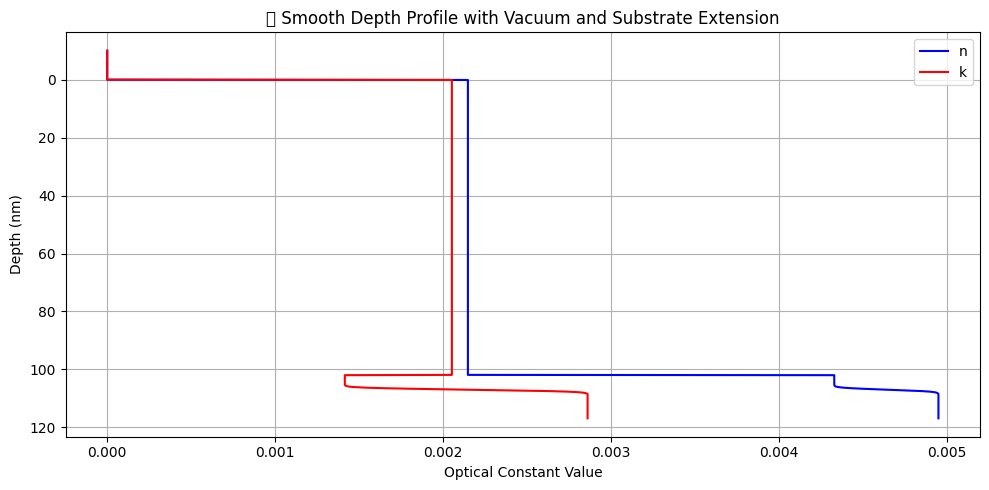

In [7]:
import matplotlib.pyplot as plt

z, n_vals, k_vals = build_centered_erf_profile(data["layers"], data["energy_pol_uni"], target_energy_index=5)

plt.figure(figsize=(10, 5))
plt.plot(n_vals, z, label="n", color="blue")
plt.plot(k_vals, z, label="k", color="red")
plt.gca().invert_yaxis()
plt.xlabel("Optical Constant Value")
plt.ylabel("Depth (nm)")
plt.title("📡 Smooth Depth Profile with Vacuum and Substrate Extension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_colored_erf_profile(z_grid, n_profile, k_profile, layers, target_energy_index=0):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Generate distinct colors for each layer + substrate
    cmap = cm.get_cmap("tab10", len(layers) + 1)
    z_current = 0

    # Plot stack layers
    for i, layer in enumerate(layers[:-1]):
        thickness, _ = get_thick_rough(layer)
        color = cmap(i)
        label = layer.get("name", f"Layer {i+1}")

        z_start = z_current
        z_end = z_current + thickness
        ax.fill_betweenx(
            z_grid,
            n_profile.min(),
            n_profile.max(),
            where=(z_grid >= z_start) & (z_grid < z_end),
            color=color,
            alpha=0.2,
            label=label
        )
        z_current = z_end

    # Add substrate region
    substrate_color = cmap(len(layers))
    substrate_label = "Substrate"
    ax.fill_betweenx(
        z_grid,
        n_profile.min(),
        n_profile.max(),
        where=(z_grid >= z_current),
        color=substrate_color,
        alpha=0.2,
        label=substrate_label
    )

    # Plot n and k profiles
    ax.plot(n_profile, z_grid, label="delta", color="black", linewidth=2)
    ax.plot(k_profile, z_grid, '--', label="beta", color="black", linewidth=2)

    ax.invert_yaxis()
    ax.set_xlabel("Optical Constant Value")
    ax.set_ylabel("Depth (nm)")
    ax.set_title("📡 Colored Depth Profile of n and k with Smooth Transitions")
    ax.grid(True)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_685941/3903873371.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(layers) + 1)
/tmp/ipykernel_685941/3903873371.py:53: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


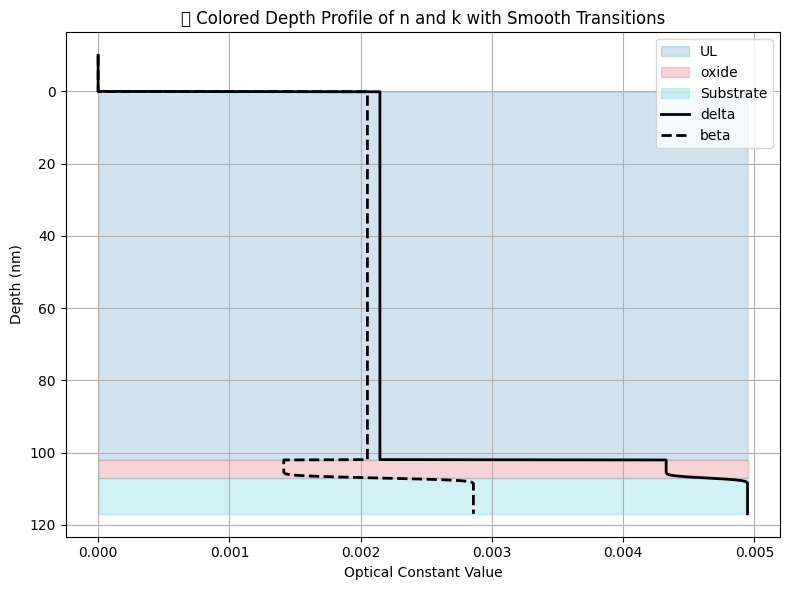

In [9]:
z, n_vals, k_vals = build_centered_erf_profile(layers, energies, target_energy_index=5)
plot_colored_erf_profile(z, n_vals, k_vals, layers, target_energy_index=5)